In [1]:
from tensorflow import keras
import tensorflow as tf
import argparse
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import cv2
from sklearn.model_selection import train_test_split
import keras
import numpy as np
import pandas as pd
import os
import keras
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras import regularizers
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
from pathlib import Path
from keras.callbacks import ModelCheckpoint
from keras.callbacks import TensorBoard

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
%%writefile download_df.py
import os
import kaggle
from os import listdir
from os.path import isfile, join
def download_df():
    if not os.path.exists("data"):
        os.makedirs("data")
    k = kaggle.KaggleApi({"username": "jdsz5paulina", "key": "5277445bf2e6cef9aac564d8f7c5b87d"})
    k.authenticate()
    print("kaggle.com: authenticated")
    k.dataset_download_cli("grassknoted/asl-alphabet", unzip=True, path="data")
    pat = "data/asl_alphabet_test/asl_alphabet_test"
    onlyfiles = [f for f in listdir(pat) if isfile(join(pat, f))]
    for o in onlyfiles:
      new_dir = o.replace("_test.jpg", "")
      if not os.path.exists(f"{pat}/{new_dir}"):
        os.makedirs(f"{pat}/{new_dir}")
      os.rename(f"{pat}/{o}", f"{pat}/{new_dir}/{o}")
if __name__ == "__main__":
    download_df()

Writing download_df.py


In [4]:
try:
  !mkdir ~/.kaggle
except:
  pass
!touch ~/.kaggle/kaggle.json
api_token = {"username": "jdsz5paulina", "key": "5277445bf2e6cef9aac564d8f7c5b87d"}
import json
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!python download_df.py

kaggle.com: authenticated
100% 1.02G/1.03G [00:10<00:00, 95.7MB/s]
100% 1.03G/1.03G [00:10<00:00, 104MB/s] 


In [6]:
train_dir = 'data/asl_alphabet_train/asl_alphabet_train'
test_dir = "data/asl_alphabet_test/asl_alphabet_test"
labels_dict = {'A':0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'J':9,'K':10,'L':11,'M':12,
                   'N':13,'O':14,'P':15,'Q':16,'R':17,'S':18,'T':19,'U':20,'V':21,'W':22,'X':23,'Y':24,
                   'Z':25,'space':26,'del':27,'nothing':28}

In [7]:
def load_data(size):
    images = []
    labels = []
    print("LOADING DATA FROM : ",end = "")
    for folder in os.listdir(train_dir):
        print(folder, end = ' | ')
        for image in os.listdir(train_dir + "/" + folder):
            temp_img = cv2.imread(train_dir + '/' + folder + '/' + image)
            temp_img = cv2.resize(temp_img, size)
            images.append(temp_img)
            labels.append(labels_dict[folder])
    
    images = np.array(images)
    images = images.astype('float32')/255.0
    
    labels = keras.utils.to_categorical(labels)
    
    X_train, X_test, Y_train, Y_test = train_test_split(images, labels, test_size = 0.05)
    print()
    print('Loaded', len(X_train),'images for training,','Train data shape =',X_train.shape)
    print('Loaded', len(X_test),'images for testing','Test data shape =',X_test.shape)
    
    return X_train, X_test, Y_train, Y_test

In [8]:
def fit_model(model, x, y, callbacks_list ,eps=5):
    model_hist = model.fit(x, y, batch_size = 200, epochs = eps, validation_split = 0.1, callbacks=callbacks_list)
    return model_hist 

In [9]:
def get_model(pretrained_model, all_character_names, IMG_SIZE, show_summary=True):
    IN_SHAPE = (*IMG_SIZE, 3)
    if pretrained_model == 'VGG16':
        pretrained_model = keras.applications.VGG16(
            include_top=False,
            input_shape=IN_SHAPE,
            weights='imagenet'
        )
    elif pretrained_model == 'ResNet152':
        pretrained_model = keras.applications.ResNet152(
            include_top=False,
            input_shape=IN_SHAPE,
            weights='imagenet'
        )
    elif pretrained_model == 'InceptionV3':
        pretrained_model = keras.applications.InceptionV3(
            include_top=False,
            input_shape=IN_SHAPE,
            weights='imagenet'
        )
    elif pretrained_model == 'DenseNet121':
        pretrained_model = keras.applications.DenseNet121(
            include_top=False,
            input_shape=IN_SHAPE,
            weights='imagenet'
        )
    elif pretrained_model == 'NASNetLarge':
        pretrained_model = keras.applications.NASNetLarge(
            include_top=False,
            input_shape=IN_SHAPE,
            weights='imagenet'
        )
    elif pretrained_model == 'EfficientNetB3':
        pretrained_model = keras.applications.EfficientNetB3(
            include_top=False,
            input_shape=IN_SHAPE,
            weights='imagenet'
        )
    elif pretrained_model == 'EfficientNetB7':
        input = Input(shape=IN_SHAPE)
        inception_model = keras.applications.EfficientNetB7(
            include_top=False,
            input_tensor=input,
            weights='imagenet'
        )
        
        flattened_outputs = [Flatten()(inception_model.output),
                             Flatten()(xception_model.output),
                             Flatten()(resnet_model.output)]
        output = Concatenate()(flattened_outputs)
        pretrained_model = Model(input, output)
    output = pretrained_model.output
    # if pretrained_model.output.shape.ndims > 2:
    #     output = Flatten()(output)
    # else:
    output = Flatten()(output)
    output = BatchNormalization()(output)
    output = Dropout(0.5)(output)
    output = Dense(512, activation='relu')(output)
        # output = BatchNormalization()(output)
        # output = Dropout(0.5)(output)
    output = Dense(all_character_names, activation='sigmoid')(output)
    model = keras.models.Model(pretrained_model.input, output)
    for layer in pretrained_model.layers:
        layer.trainable = False
    if show_summary:
        model.summary(line_length=200)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [10]:
def save_model(model, pat, name):
  if not os.path.exists(pat):
      os.makedirs(pat)
  try:
    model.save(f"{pat}/{name}.h5")
    print("Saved model to disk")
  except:
    pass

In [11]:
def save_charts(history, pat, name):
  if not os.path.exists(pat):
      os.makedirs(pat)
  try:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig(f"{pat}/{name}.png")
    print("Saved chart to disk")
  except:
    pass

In [12]:
import os, shutil, pathlib, fnmatch

def move_dir(src: str, dst: str, pattern: str = '*'):
    if not os.path.isdir(dst):
        pathlib.Path(dst).mkdir(parents=True, exist_ok=True)
    for f in fnmatch.filter(os.listdir(src), pattern):
        shutil.move(os.path.join(src, f), os.path.join(dst, f))

In [13]:
def iter_models(pretrained_model_list):
  for pm, size, epochs in pretrained_model_list:
    try:
      print(f"fitting: {pm} in size: {size}")
      name = f"model={pm}_size={size}_epochs={epochs}"
      disk_path = "/content/gdrive/My Drive/dl_project"
      trained_model = Path(f"{disk_path}/models/{pm}/{name}.h5")

      if not os.path.exists(f"{disk_path}/models/{pm}"):
          os.makedirs(f"{disk_path}/models/{pm}")
      if not os.path.exists(f"{disk_path}/models/{pm}/logs"):
          os.makedirs(f"{disk_path}/models/{pm}/logs")
      if trained_model.is_file():
          continue

      X_train, X_test, Y_train, Y_test = load_data(size=size)
      mod = get_model(pm, 29, size, show_summary=False)
      model_checkpoint_name = "{epoch:02d}-{accuracy:.2f}.h5"
      checkpoint = ModelCheckpoint(f"{disk_path}/models/{pm}/{pm}-{model_checkpoint_name}", monitor='accuracy', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
      callbacks_list = [
        checkpoint,
        TensorBoard(log_dir="logs"),
      ]
      history = fit_model(mod, X_train, Y_train, callbacks_list, eps=epochs)
      save_model(mod, f"{disk_path}/models/{pm}", name)
      save_charts(history, f"{disk_path}/models/{pm}/charts", name)
      try:
        move_dir("logs", f"{disk_path}/models/{pm}/logs")
        import gc
        gc.collect()
      except Exception as ex:
        print(ex)
    except Exception as e:
      print(e)

In [14]:
!nvidia-smi

Thu Jul 30 10:03:27 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   69C    P8    33W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

fitting: DenseNet121 in size: (71, 71)
LOADING DATA FROM : B | K | I | Y | M | R | E | Z | L | del | P | N | nothing | U | X | H | V | W | J | O | Q | space | G | S | A | T | F | C | D | 
Loaded 82650 images for training, Train data shape = (82650, 71, 71, 3)
Loaded 4350 images for testing Test data shape = (4350, 71, 71, 3)
29089792/29084464 [==============================] - 0s 0us/step
Train on 74385 samples, validate on 8265 samples
Epoch 1/12
74385/74385 [==============================] - 154s 2ms/step - loss: 0.4217 - accuracy: 0.8802 - val_loss: 3.6675 - val_accuracy: 0.3250

Epoch 00001: saving model to /content/gdrive/My Drive/dl_project/models/DenseNet121/DenseNet121-01-0.88.h5
Epoch 2/12
74385/74385 [==============================] - 135s 2ms/step - loss: 0.1009 - accuracy: 0.9668 - val_loss: 3.5023 - val_accuracy: 0.4076

Epoch 00002: saving model to /content/gdrive/My Drive/dl_project/models/DenseNet121/DenseNet121-02-0.97.h5
Epoch 3/12
74385/74385 [=======================

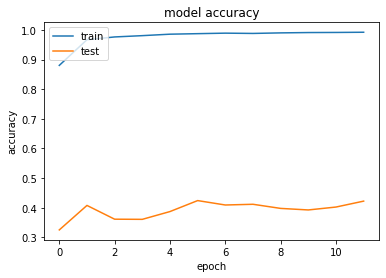

In [15]:
  pretrained_model_list = [
                           # ('VGG16', (71, 71), 12),
                           # ('ResNet152', (71, 71), 12),
                           # ('InceptionV3', (71, 71), 12),
                           ('DenseNet121', (71, 71), 12),
                           # ('NASNetLarge', (71, 71), 12)
                           # ('EfficientNetB3', (71, 71), 12)
                           # ('EfficientNetB7', (71, 71), 12)
                           ]
iter_models(pretrained_model_list)